# <center> Amazon Product Recomendation using Singular Value Decomposition(SVD) </center>


# Importing Libraries and Data

In [4]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import scipy.sparse
import warnings; warnings.simplefilter('ignore')
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [5]:
%matplotlib inline

In [6]:
#Data set doesn't contain any coloumns names so adding names for coloumns while importing the data
columns=['userId', 'productId', 'ratings','timestamp']
electronics_df=pd.read_csv('Amazon_Electronics.csv',names=columns)

In [7]:
electronics_df.head()

,userId,productId,ratings,timestamp
0,AKM1MP6P0OYPR,0132793040,5.0,1365811200
1,A2CX7LUOHB2NDG,0321732944,5.0,1341100800
2,A2NWSAGRHCP8N5,0439886341,1.0,1367193600
3,A2WNBOD3WNDNKT,0439886341,3.0,1374451200
4,A1GI0U4ZRJA8WN,0439886341,1.0,1334707200


In [8]:
#Droping the timestamp coloumn
electronics_df.drop('timestamp',axis=1,inplace=True)
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7824482 entries, 0 to 7824481
Data columns (total 3 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     object 
 1   productId  object 
 2   ratings    float64
dtypes: float64(1), object(2)
memory usage: 179.1+ MB


In [9]:
#Checking the no.of rows and columns
rows,columns=electronics_df.shape
print('Number of rows: ',rows)
print('Number of columns: ',columns)

Number of rows:  7824482
Number of columns:  3


Since the data is very big. Consider dataframe with first 100000 rows and all columns from 0 of dataset.

In [10]:
#Taking subset of the dataset
electronics_df=electronics_df.iloc[:1000000,0:]
electronics_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   userId     1000000 non-null  object 
 1   productId  1000000 non-null  object 
 2   ratings    1000000 non-null  float64
dtypes: float64(1), object(2)
memory usage: 22.9+ MB


In [11]:
#Summary statistics of rating variable
electronics_df['ratings'].describe().transpose()

count    1000000.000000
mean           3.973620
std            1.399741
min            1.000000
25%            3.000000
50%            5.000000
75%            5.000000
max            5.000000
Name: ratings, dtype: float64

In [12]:
#Finding the minimum and maximum ratings
print('Minimum rating is: %d' %(electronics_df.ratings.min()))
print('Maximum rating is: %d' %(electronics_df.ratings.max()))

Minimum rating is: 1
Maximum rating is: 5


In [13]:
#Checking for missing values
print('Number of missing values across columns: \n',electronics_df.isnull().sum())

Number of missing values across columns: 
 userId       0
productId    0
ratings      0
dtype: int64


In [14]:
#Droping the missing values
electronics_df=electronics_df.dropna()

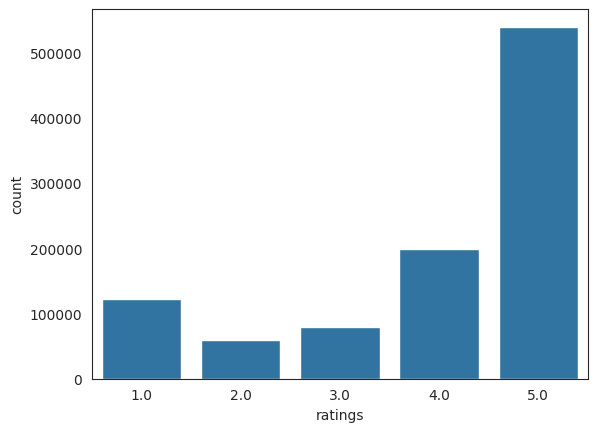

In [15]:
# Checking the distribution of the rating
with sns.axes_style('white'):
    g = sns.countplot(electronics_df, x='ratings')

In [16]:
# Counting no.of unique user id  in the data
print('Number of unique users in Raw data = ', electronics_df['userId'].nunique())
# Number of unique product id  in the data
print('Number of unique product in Raw data = ', electronics_df['productId'].nunique())

Number of unique users in Raw data =  754153
Number of unique product in Raw data =  59634


In [17]:
#Checking the top 10 users based on ratings
most_rated=electronics_df.groupby('userId').size().sort_values(ascending=False)[:10]
print('Top 10 users based on ratings: \n',most_rated)

Top 10 users based on ratings: 
 userId
A5JLAU2ARJ0BO     409
A231WM2Z2JL0U3    249
A25HBO5V8S8SEA    164
A6FIAB28IS79      138
AT6CZDCP4TRGA     125
AKT8TGIT6VVZ5     122
A11D1KHM7DVOQK    112
A2B7BUH8834Y6M    103
A3OXHLG6DIBRW8     94
A2R6RA8FRBS608     88
dtype: int64


In [18]:
counts=electronics_df.userId.value_counts()
electronics_df_final=electronics_df[electronics_df.userId.isin(counts[counts>=15].index)]
print('Number of users who have rated 25 or more items =', len(electronics_df_final))
print('Number of unique users in the final data = ', electronics_df_final['userId'].nunique())
print('Number of unique products in the final data = ', electronics_df_final['userId'].nunique())

Number of users who have rated 25 or more items = 18819
Number of unique users in the final data =  763
Number of unique products in the final data =  763


In [19]:
# Rating analysis
final_ratings_matrix = electronics_df_final.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
final_ratings_matrix.head()

productId,0970407998,0972683275,1400532620,1400532655,140053271X,1400599997,1400699169,1685560148,7040034018,7562434166,...,B000HDIYEO,B000HDJT4S,B000HDJY7K,B000HDKVEA,B000HDKZPU,B000HDL05O,B000HDMRNS,B000HDMUU8,B000HDONSK,B000HDQ2G6
userId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A101OAAMZYWQ3U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A109LWN9DUGPDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10C84Y38RT22P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

Shape of final_ratings_matrix:  (763, 10212)


In [21]:
#Calucating the density of the rating marix
given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))

given_num_of_ratings =  18819
possible_num_of_ratings =  7791756
density: 0.24%


In [22]:
#Split the data into train and test datasets into 70:30 ratio
from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(electronics_df_final, test_size = 0.3, random_state=0)
train_data.head()

,userId,productId,ratings
104125,AT2J7H5TRZM8Z,B00005M011,4.0
83663,A4WEZJOIZIV4U,B000053HH5,5.0
936134,AYB4ELCS5AM8P,B000FJEYZ8,5.0
785615,A6FIAB28IS79,B000BVV2IC,4.0
658661,A1GF4BH6WPBZ4Y,B0009CDYF2,2.0


In [23]:
print('Shape of training data: ',train_data.shape)
print('Shape of testing data: ',test_data.shape)

Shape of training data:  (13173, 3)
Shape of testing data:  (5646, 3)


# Building Recomendation model

In [24]:
#Counting recommendation score  of user_id for each unique product
train_data_grouped = train_data.groupby('productId').agg({'userId': 'count'}).reset_index()
train_data_grouped.rename(columns = {'userId': 'score'},inplace=True)
train_data_grouped.head(40)

,productId,score
0,0970407998,1
1,0972683275,2
2,1400532620,1
3,1400532655,4
4,1400699169,1
5,1685560148,1
6,7562434166,1
7,787988002X,2
8,9623499043,1
9,998376234X,1


In [25]:
#Sort the products on recommendation score
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])

In [26]:
#Generating a recommendation rank based upon score
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first')

In [27]:
#Geting the recommendations
popularity_recommendations = train_data_sort.head(10)
popularity_recommendations

,productId,score,rank
2477,B00007KDVI,33,1.0
2396,B00007E7JU,30,2.0
392,B00004SB92,26,3.0
783,B00004ZCJE,24,4.0
1127,B00005LEN4,24,5.0
4795,B0002L5R78,23,6.0
2214,B00006JN3G,22,7.0
2975,B00009R6TA,22,8.0
4562,B0002CPBWI,22,9.0
3485,B0000BZL1P,19,10.0


In [28]:
#Sorting the products on recommendation score
train_data_sort = train_data_grouped.sort_values(['score', 'productId'], ascending = [0,1])

In [29]:
#Generating a recommendation rank based upon score
train_data_sort['rank'] = train_data_sort['score'].rank(ascending=0, method='first')

In [30]:
#Get the top 5 recommendations
popularity_recommendations = train_data_sort.head(5)
popularity_recommendations

,productId,score,rank
2477,B00007KDVI,33,1.0
2396,B00007E7JU,30,2.0
392,B00004SB92,26,3.0
783,B00004ZCJE,24,4.0
1127,B00005LEN4,24,5.0


In [31]:
# Using the recommender model to make predictions
def recommend(user_id):
    user_recommendations = popularity_recommendations

    #Adding user_id column for which the recommendations are being generated
    user_recommendations['userId'] = user_id

    #Bringing user_id column to the front
    cols = user_recommendations.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    user_recommendations = user_recommendations[cols]

    return user_recommendations

In [32]:
find_recom = [10,100,150]   # This list is user choice.
for i in find_recom:
    print("The list of recommendations for the userId: %d\n" %(i))
    print(recommend(i))
    print("\n")

The list of recommendations for the userId: 10

      userId   productId  score  rank
2477      10  B00007KDVI     33   1.0
2396      10  B00007E7JU     30   2.0
392       10  B00004SB92     26   3.0
783       10  B00004ZCJE     24   4.0
1127      10  B00005LEN4     24   5.0


The list of recommendations for the userId: 100

      userId   productId  score  rank
2477     100  B00007KDVI     33   1.0
2396     100  B00007E7JU     30   2.0
392      100  B00004SB92     26   3.0
783      100  B00004ZCJE     24   4.0
1127     100  B00005LEN4     24   5.0


The list of recommendations for the userId: 150

      userId   productId  score  rank
2477     150  B00007KDVI     33   1.0
2396     150  B00007E7JU     30   2.0
392      150  B00004SB92     26   3.0
783      150  B00004ZCJE     24   4.0
1127     150  B00005LEN4     24   5.0




In [33]:
electronics_df_CF = pd.concat([train_data, test_data]).reset_index()
electronics_df_CF.head()

,index,userId,productId,ratings
0,104125,AT2J7H5TRZM8Z,B00005M011,4.0
1,83663,A4WEZJOIZIV4U,B000053HH5,5.0
2,936134,AYB4ELCS5AM8P,B000FJEYZ8,5.0
3,785615,A6FIAB28IS79,B000BVV2IC,4.0
4,658661,A1GF4BH6WPBZ4Y,B0009CDYF2,2.0


# User Based Collaborative Filtering model

In [34]:
# Matrix with row per 'user' and column per 'item'
pivot_df = electronics_df_CF.pivot(index = 'userId', columns ='productId', values = 'ratings').fillna(0)
pivot_df.head()

productId,0970407998,0972683275,1400532620,1400532655,140053271X,1400599997,1400699169,1685560148,7040034018,7562434166,...,B000HDIYEO,B000HDJT4S,B000HDJY7K,B000HDKVEA,B000HDKZPU,B000HDL05O,B000HDMRNS,B000HDMUU8,B000HDONSK,B000HDQ2G6
userId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A101OAAMZYWQ3U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A109LWN9DUGPDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10C84Y38RT22P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
print('Shape of the pivot table: ', pivot_df.shape)

Shape of the pivot table:  (763, 10212)


In [36]:
pivot_df['user_index'] = np.arange(0, pivot_df.shape[0], 1)
pivot_df.head()

productId,0970407998,0972683275,1400532620,1400532655,140053271X,1400599997,1400699169,1685560148,7040034018,7562434166,...,B000HDJT4S,B000HDJY7K,B000HDKVEA,B000HDKZPU,B000HDL05O,B000HDMRNS,B000HDMUU8,B000HDONSK,B000HDQ2G6,user_index
userId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
A101OAAMZYWQ3U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
A109LWN9DUGPDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
A10C84Y38RT22P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4


In [37]:
pivot_df.set_index(['user_index'], inplace=True)
# Ratings given by users
pivot_df.head()

productId,0970407998,0972683275,1400532620,1400532655,140053271X,1400599997,1400699169,1685560148,7040034018,7562434166,...,B000HDIYEO,B000HDJT4S,B000HDJY7K,B000HDKVEA,B000HDKZPU,B000HDL05O,B000HDMRNS,B000HDMUU8,B000HDONSK,B000HDQ2G6
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [38]:
# Singular Value Decomposition
from scipy.sparse.linalg import svds
from scipy.sparse import csr_matrix

U, sigma, Vt = svds(pivot_df.to_numpy(), k = 10)

In [39]:
print('Left singular matrix: \n',U)

Left singular matrix: 
 [[ 0.00761022 -0.00302789 -0.023853   ...  0.00120132 -0.0019842
  -0.00148965]
 [-0.00228398 -0.03074383 -0.00224179 ...  0.00067666 -0.00022541
  -0.00148397]
 [ 0.00704786  0.01038655 -0.02394648 ...  0.00108403 -0.00178205
  -0.00104581]
 ...
 [ 0.00313382  0.01000675 -0.0175664  ...  0.00057475 -0.00105753
  -0.00064982]
 [-0.00948548  0.01635936 -0.03404967 ...  0.00096881 -0.00171398
  -0.00104302]
 [ 0.0049167  -0.00206821  0.00305467 ...  0.00025286  0.00051783
  -0.00315895]]


In [40]:
print('Sigma: \n',sigma)

Sigma: 
 [43.1544664  43.72298779 45.64477073 46.67645111 50.80556094 52.95299001
 60.04365979 63.6820654  70.37862065 85.48430813]


In [41]:
# Constructing sigma into diagonal array
sigma = np.diag(sigma)
print('Diagonal matrix: \n',sigma)

Diagonal matrix: 
 [[43.1544664   0.          0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.         43.72298779  0.          0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.         45.64477073  0.          0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.         46.67645111  0.          0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.         50.80556094  0.
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.         52.95299001
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
  60.04365979  0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.
   0.         63.6820654   0.          0.        ]
 [ 0.          0.          0.        

In [42]:
print('Right singular matrix: \n',Vt)

Right singular matrix: 
 [[-1.73492761e-04  2.42056822e-04  2.31706392e-04 ...  4.97624044e-04
   7.29085771e-05 -3.80014813e-03]
 [ 2.24803321e-03  4.98161724e-04 -6.39173839e-05 ... -1.89754361e-04
   3.54622285e-04 -2.90908504e-03]
 [ 2.15605715e-03 -2.09361602e-04 -7.58497297e-05 ... -4.73083720e-05
  -2.27670334e-03 -2.69568599e-03]
 ...
 [ 4.03418169e-04  5.43266290e-05  6.11771721e-05 ... -4.63325705e-06
   8.50112430e-05  2.09085518e-03]
 [-4.43998487e-04 -1.14515796e-04 -1.19589537e-05 ... -5.12415208e-05
  -8.08334456e-05 -1.48932691e-03]
 [-1.56543861e-04 -6.09447202e-05 -4.63817510e-06 ... -1.89308624e-05
  -4.89126824e-05 -2.09234520e-03]]


In [43]:
#Predicted ratings
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt)
# Convert predicted ratings to dataframe
preds_df = pd.DataFrame(all_user_predicted_ratings, columns = pivot_df.columns)
preds_df.head()

productId,0970407998,0972683275,1400532620,1400532655,140053271X,1400599997,1400699169,1685560148,7040034018,7562434166,...,B000HDIYEO,B000HDJT4S,B000HDJY7K,B000HDKVEA,B000HDKZPU,B000HDL05O,B000HDMRNS,B000HDMUU8,B000HDONSK,B000HDQ2G6
0,0.000562,0.002531,0.000215,0.007984,0.000383,0.000705,0.002927,0.003225,0.001270,0.000614,...,0.001391,0.042097,0.002142,0.000164,0.000434,0.008377,0.008331,0.000519,0.003971,0.020328
1,-0.003392,-0.000256,0.000077,0.000160,0.000032,0.000698,0.003391,0.003850,0.000669,0.000370,...,0.001002,0.041937,0.000373,0.000121,-0.000181,0.000582,0.013057,0.000232,-0.000219,0.008799
2,0.000061,0.004065,0.000182,0.008523,0.000854,0.000467,0.001614,0.001447,0.001634,0.000449,...,0.000857,0.055384,0.002373,0.000116,0.000635,0.009864,0.002192,0.000424,0.004142,0.016954
3,-0.000651,0.001400,0.000035,0.007533,0.000741,0.000232,-0.000044,-0.000233,0.000784,-0.000006,...,0.000221,0.004681,0.000217,0.000017,0.000050,0.001130,0.001338,0.000160,-0.000356,-0.000129
4,0.000380,0.000614,0.000004,0.002374,0.000461,0.000162,0.000086,0.000109,0.000254,0.000043,...,0.000230,0.002261,0.000250,0.000014,0.000045,0.000717,0.000132,0.000049,0.000058,0.002693


In [44]:
# Recommending the items with the highest predicted ratings
def recommend_items(userID, pivot_df, preds_df, num_recommendations):
    # index starts at 0
    user_idx = userID-1
    # Get and sort the user's ratings
    sorted_user_ratings = pivot_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_ratings
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    #sorted_user_predictions
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    temp = temp.loc[temp.user_ratings == 0]
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_id = {}):\n'.format(userID))
    print(temp.head(num_recommendations))

Testing the prediction to see model recomending different items based on user behaviour

In [45]:
#Testing the recomendation
userID = 5
num_recommendations = 10
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 5):

                   user_ratings  user_predictions
Recommended Items                                
B00004SB92                  0.0          0.054898
B00005LB8P                  0.0          0.049994
B0000632FZ                  0.0          0.046664
B00008OE6I                  0.0          0.046245
B00006B7HB                  0.0          0.043536
B00007KDVI                  0.0          0.043386
B00006JHTQ                  0.0          0.040532
B00004TS16                  0.0          0.040413
B00006I5FQ                  0.0          0.039808
B00004S9AK                  0.0          0.039762


In [46]:
#Testing the recomendation
userID = 2
num_recommendations = 10
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 2):

                   user_ratings  user_predictions
Recommended Items                                
B00005LEN4                  0.0          0.281791
B000BY52NK                  0.0          0.191755
B000FKQ8LA                  0.0          0.181842
B0008D76L0                  0.0          0.165565
B00007EDZG                  0.0          0.144419
B00009R6TA                  0.0          0.139636
B0009H5VVM                  0.0          0.138851
B0000E68U2                  0.0          0.122662
B0002MQGOK                  0.0          0.121914
B000BN94F8                  0.0          0.120522


In [47]:
#Testing the recomendation
userID = 10
num_recommendations = 10
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 10):

                   user_ratings  user_predictions
Recommended Items                                
B00081A2KY                  0.0          0.830215
B00004Z5M1                  0.0          0.686694
B000067VBL                  0.0          0.612575
B00004SB92                  0.0          0.611557
B00029U1DK                  0.0          0.569996
B0002L5R78                  0.0          0.509175
B00004ZCJE                  0.0          0.498296
B00007KDVI                  0.0          0.481431
B00065DGNC                  0.0          0.472165
B0002375F8                  0.0          0.468891


# Evaluation of Recommendation Model

In [48]:
# Actual ratings given by the users
final_ratings_matrix.head()

productId,0970407998,0972683275,1400532620,1400532655,140053271X,1400599997,1400699169,1685560148,7040034018,7562434166,...,B000HDIYEO,B000HDJT4S,B000HDJY7K,B000HDKVEA,B000HDKZPU,B000HDL05O,B000HDMRNS,B000HDMUU8,B000HDONSK,B000HDQ2G6
userId,,,,,,,,,,,,,,,,,,,,,
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A101OAAMZYWQ3U,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A109LWN9DUGPDP,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10C84Y38RT22P,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# Average of ACTUAL ratings for each item
final_ratings_matrix.mean().head()

productId
0970407998    0.005242
0972683275    0.013106
1400532620    0.001311
1400532655    0.018349
140053271X    0.006553
dtype: float64

In [50]:
# Predicted ratings
preds_df.head()

productId,0970407998,0972683275,1400532620,1400532655,140053271X,1400599997,1400699169,1685560148,7040034018,7562434166,...,B000HDIYEO,B000HDJT4S,B000HDJY7K,B000HDKVEA,B000HDKZPU,B000HDL05O,B000HDMRNS,B000HDMUU8,B000HDONSK,B000HDQ2G6
0,0.000562,0.002531,0.000215,0.007984,0.000383,0.000705,0.002927,0.003225,0.001270,0.000614,...,0.001391,0.042097,0.002142,0.000164,0.000434,0.008377,0.008331,0.000519,0.003971,0.020328
1,-0.003392,-0.000256,0.000077,0.000160,0.000032,0.000698,0.003391,0.003850,0.000669,0.000370,...,0.001002,0.041937,0.000373,0.000121,-0.000181,0.000582,0.013057,0.000232,-0.000219,0.008799
2,0.000061,0.004065,0.000182,0.008523,0.000854,0.000467,0.001614,0.001447,0.001634,0.000449,...,0.000857,0.055384,0.002373,0.000116,0.000635,0.009864,0.002192,0.000424,0.004142,0.016954
3,-0.000651,0.001400,0.000035,0.007533,0.000741,0.000232,-0.000044,-0.000233,0.000784,-0.000006,...,0.000221,0.004681,0.000217,0.000017,0.000050,0.001130,0.001338,0.000160,-0.000356,-0.000129
4,0.000380,0.000614,0.000004,0.002374,0.000461,0.000162,0.000086,0.000109,0.000254,0.000043,...,0.000230,0.002261,0.000250,0.000014,0.000045,0.000717,0.000132,0.000049,0.000058,0.002693


In [51]:
# Average of PREDICTED ratings for each item
preds_df.mean().head()

productId
0970407998    0.004511
0972683275    0.001800
1400532620    0.000141
1400532655    0.007727
140053271X    0.000780
dtype: float64

In [52]:
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(10212, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
productId,,,
0970407998,0.005242,0.004511,0
0972683275,0.013106,0.001800,1
1400532620,0.001311,0.000141,2
1400532655,0.018349,0.007727,3
140053271X,0.006553,0.000780,4


In [53]:
RMSE = round((((rmse_df.Avg_actual_ratings - rmse_df.Avg_predicted_ratings) ** 2).mean() ** 0.5), 5)
print('\nRMSE = {} \n'.format(RMSE))


RMSE = 0.00738 



#  Testing the Recomendation Model

In [54]:
# In this example we are getting recomendations for userID 15 with 10 recomendations
userID = 15 #user ID
num_recommendations = 10 # number of recomendations
recommend_items(userID, pivot_df, preds_df, num_recommendations)


Below are the recommended items for user(user_id = 15):

                   user_ratings  user_predictions
Recommended Items                                
B0002L5R78                  0.0          0.268561
B00004Z5M1                  0.0          0.250253
B00004ZCJE                  0.0          0.242069
B00004SB92                  0.0          0.241985
B00007KDVI                  0.0          0.232786
B00008OE6I                  0.0          0.216375
B00007E7JU                  0.0          0.198302
B00004S9AK                  0.0          0.180757
B00004TS16                  0.0          0.180530
B00004VX3T                  0.0          0.175965


# Conclusion

- Popularity-based recommender systems are not tailored to each user and rely on frequency counts, which may not be ideal for them.As we can see, there is a difference between the recommendations made by the Popularity based model and the Collaborative Filtering based model for users ids 4, 6, and 8. The former gave the same set of five products, while the latter gave an entirely different list based on the user's previous purchase history.

- Model-based Collaborative Filtering is a personalized recommender system that doesn't rely on any extra data; instead, it bases its recommendations on the user's historical behavior.